[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ryansteed/image-gpt-bias/blob/master/notebooks/experiments.ipynb)

# Image GPT Bias
**Image Embedding Association Test**

Ryan Steed

This script adapted from https://colab.research.google.com/github/apeguero1/image-gpt/blob/master/Transformers_Image_GPT.ipynb.


In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

%load_ext autoreload
%autoreload 2

# %cd /Users/steed/caliskan/git/image-gpt-bias

## Download Model

In [2]:
!nvidia-smi #OpenAI says you need 16GB GPU for the large model, but it may work if you lower n_sub_batch on the others.

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
import urllib

# don't share these to Github or elsewhere!
u = "your_username"
p = urllib.parse.quote("your_password")
!git clone --recurse-submodules -j8 https://$u:$p@github.com/$u/image-gpt-bias.git
%cd image-gpt-bias

fatal: destination path 'image-gpt-bias' already exists and is not an empty directory.
/content/image-gpt-bias


In [5]:
# note - you may need to restart the kernel for these installations to take effect
!pip install -e .
!pip install -e weat

Obtaining file:///content/image-gpt-bias
     |████████████████████████████████| 890kB 7.6MB/s 
     |████████████████████████████████| 890kB 28.9MB/s 
     |████████████████████████████████| 1.1MB 49.8MB/s 
     |████████████████████████████████| 3.0MB 49.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=0192b1d5778042b13d5ed2d957ee6583dade62ebde7ff12311456a4835bf6093
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
  Running setup.py develop for ieat
Obtaining file:///content/image-gpt-bias/weat
  Running setup.py develop for weat


In [5]:
model_sizes = ["s", "m", "l"] #small medium large, xl not available
model_size = "l"
models_dir = "models"
color_clusters_dir = "clusters"
n_px = 32

In [6]:
# download the model - skip if already downloaded
!python image-gpt/download.py --model {model_size} --ckpt 1000000 --clusters --download_dir {models_dir}/{model_size}
!python image-gpt/download.py --clusters --download_dir {color_clusters_dir}

input args:
 {
    "download_dir":"models/l",
    "model":"l",
    "ckpt":"1000000",
    "clusters":true,
    "dataset":null
}
Fetching model.ckpt-1000000.data-00000-of-00064: 1.00kit [00:00, 764kit/s]      
Fetching model.ckpt-1000000.data-00001-of-00064: 252Mit [00:04, 61.1Mit/s]      
Fetching model.ckpt-1000000.data-00002-of-00064: 249Mit [00:04, 55.4Mit/s]      
Fetching model.ckpt-1000000.data-00003-of-00064: 249Mit [00:04, 53.3Mit/s]      
Fetching model.ckpt-1000000.data-00004-of-00064: 274Mit [00:03, 72.0Mit/s]      
Fetching model.ckpt-1000000.data-00005-of-00064: 255Mit [00:03, 63.8Mit/s]      
Fetching model.ckpt-1000000.data-00006-of-00064: 255Mit [00:03, 75.8Mit/s]      
Fetching model.ckpt-1000000.data-00007-of-00064: 264Mit [00:03, 71.2Mit/s]      
Fetching model.ckpt-1000000.data-00008-of-00064: 245Mit [00:03, 67.2Mit/s]      
Fetching model.ckpt-1000000.data-00009-of-00064: 258Mit [00:03, 69.9Mit/s]      
Fetching model.ckpt-1000000.data-00010-of-00064: 245Mit [00:03,

## Embedding Extraction

Prior implementations:
- SENT (w/ jiant) - https://github.com/W4ngatang/sent-bias
- Tan & Celis (w/ HuggingFace) - https://github.com/tanyichern/social-biases-contextualized

In [ ]:
from ieat.models import EmbeddingExtractor

extractor = EmbeddingExtractor(
    model_size=model_size,
    models_dir=models_dir,
    color_clusters_dir=color_clusters_dir,
    n_px=n_px
)
extractor

### Step-By-Step Demo

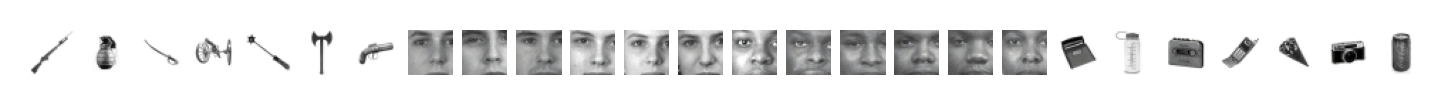

In [ ]:
test_dir = "data/weapon"
image_paths = [os.path.join(test_dir, d, f) for d in os.listdir(test_dir) for f in os.listdir(os.path.join(test_dir, d))]
_ = extractor.process_samples(image_paths, visualize=True)

In [ ]:
output_path = "embeddings/weapon.csv"
extractor.extract(image_paths, output_path=output_path)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
img,,,,,,,,,,,,,,,,,,,,,
rifle.jpg,15.385178,10.567719,8.773263,9.552052,9.221087,13.118824,8.898617,10.505133,10.374969,8.633853,...,10.655484,8.040053,13.910337,16.142334,13.942163,10.575271,18.534674,21.963984,8.093419,11.735118
grenade.jpg,14.516444,10.309349,8.235927,9.635322,9.448365,12.370226,8.948378,10.386996,9.625449,8.528605,...,10.041757,8.135211,13.122416,15.392340,13.359159,10.189865,17.699184,21.547512,7.121128,11.751795
sword.jpg,14.875776,10.406982,8.429152,9.306886,8.957664,12.815912,8.654018,10.066076,9.859778,8.435455,...,10.418196,8.116982,13.643312,15.938161,13.595427,10.556729,17.745373,21.583744,7.709558,11.482836
cannon.jpg,15.714258,10.833429,8.496162,9.695824,9.544368,12.812616,9.147958,10.677876,10.455327,8.774539,...,10.404643,8.125225,14.155001,16.256985,14.132948,10.561037,18.479136,22.323254,8.037404,12.340572
mace.jpg,13.358615,8.931422,6.925794,7.954681,8.066824,10.997238,7.271123,8.948318,8.394958,7.035842,...,8.840185,6.401076,12.025066,14.224137,11.720935,9.065306,16.824419,20.122969,6.438962,10.177368
axe.jpg,15.442507,10.853559,8.301301,9.836548,9.284307,12.908263,9.304977,10.522963,10.545900,8.931809,...,9.745117,7.619501,13.660414,16.306650,13.722888,10.451452,17.973421,21.978298,7.986808,12.093969
revolver.jpg,15.994201,10.992706,8.763406,9.680336,9.366932,13.133907,8.920437,10.723027,10.475836,8.894149,...,10.912344,8.439634,14.241138,16.360710,14.088060,10.945549,18.426096,22.035797,8.190693,12.310879
wm1.jpg,0.053752,-2.679754,0.910424,-0.605343,0.336831,6.269164,-0.486558,-0.663159,-3.010507,-0.774463,...,0.250178,-1.601684,1.478524,1.463020,1.329845,-0.942064,16.745441,6.409237,-3.742612,-0.360373
wm6.jpg,-2.948333,-4.874415,-0.515118,-2.057206,-2.181390,3.704029,-2.670585,-2.289844,-3.943339,-3.158143,...,0.860211,-3.235828,-1.264703,-1.985677,-1.682443,0.030391,10.781816,3.555405,-6.047253,-2.695228


In [ ]:
# to download from colab
from google.colab import files

files.download(output_path)

## Experiments

### Baselines

In [ ]:
import pandas as pd

valence_words = pd.read_csv("data/bgb_pleasant-words.csv").set_index("word")
q = 0.8
p = 0.8
m = 0.25

In [ ]:
# high pleasantness
valence_words[
    (valence_words.pleasantness > valence_words.pleasantness.quantile(q=q)) &
    (valence_words.imagery > valence_words.imagery.quantile(q=p))
].sort_values("imagery", ascending=False)[["pleasantness", "imagery"]]

,pleasantness,imagery
word,,
beach,4.51,4.82
ocean,4.41,4.80
baby,4.45,4.79
mother,4.56,4.79
sunrise,4.68,4.75
diamond,4.51,4.74
rainbow,4.55,4.72
money,4.41,4.70
father,4.43,4.69


In [ ]:
# low pleasantness
valence_words[
    (valence_words.pleasantness < valence_words.pleasantness.quantile(q=(1-q))) &
    (valence_words.imagery > valence_words.imagery.quantile(q=p-m))
].sort_values("imagery")[["pleasantness", "imagery"]]

,pleasantness,imagery
word,,
killer,1.20,3.82
fungus,1.60,3.82
rape,1.22,3.87
morgue,1.50,3.89
crucify,1.42,3.90
death,1.47,3.93
slum,1.46,3.94
devil,1.37,3.95
flabby,1.60,3.95


### IATs

#### Weapons

09/05 07:52:19 PM: Extracting embeddings for black


black


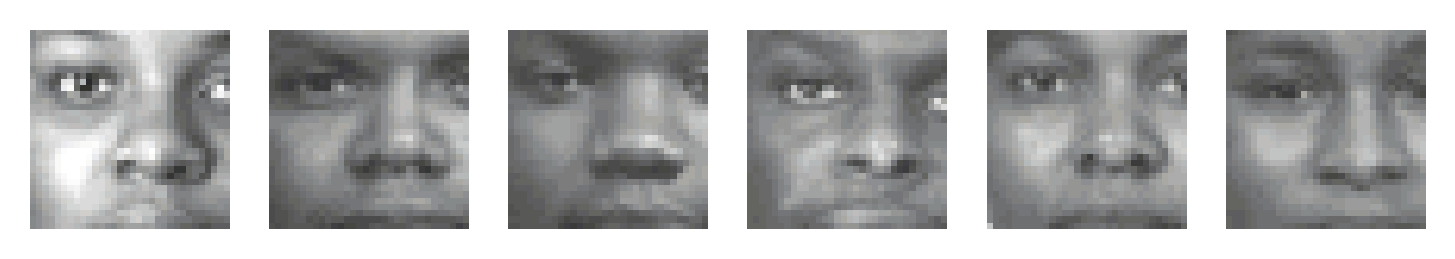

09/05 07:54:15 PM: Extracting embeddings for white


white


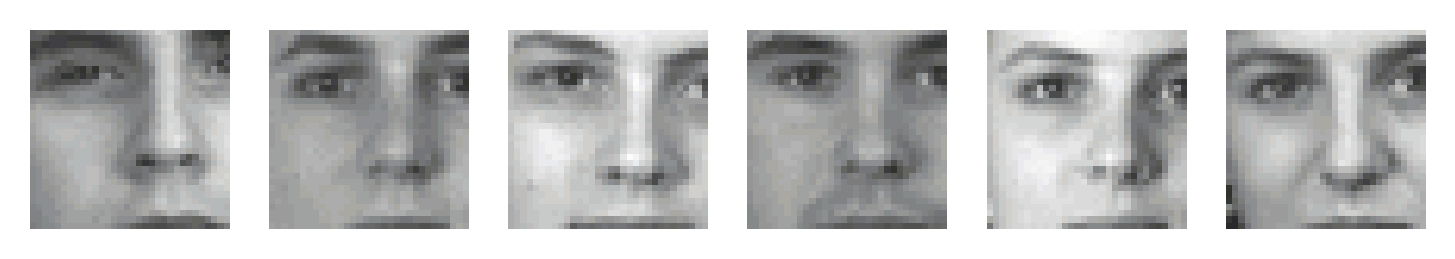

09/05 07:56:10 PM: Extracting embeddings for tool


tool


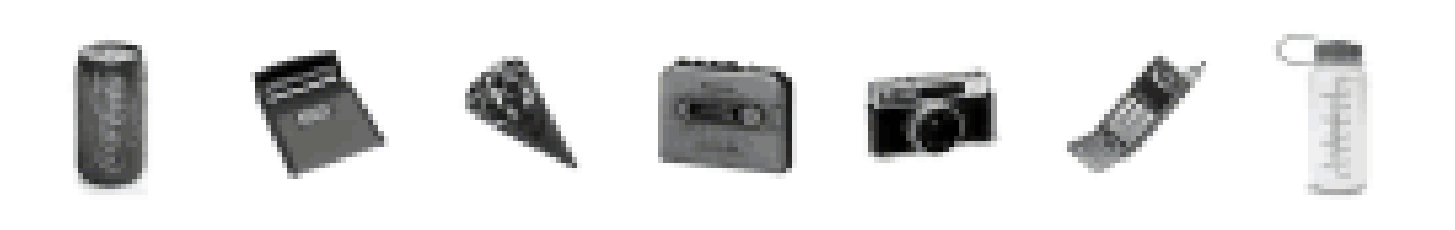

09/05 07:58:27 PM: Extracting embeddings for weapon


weapon


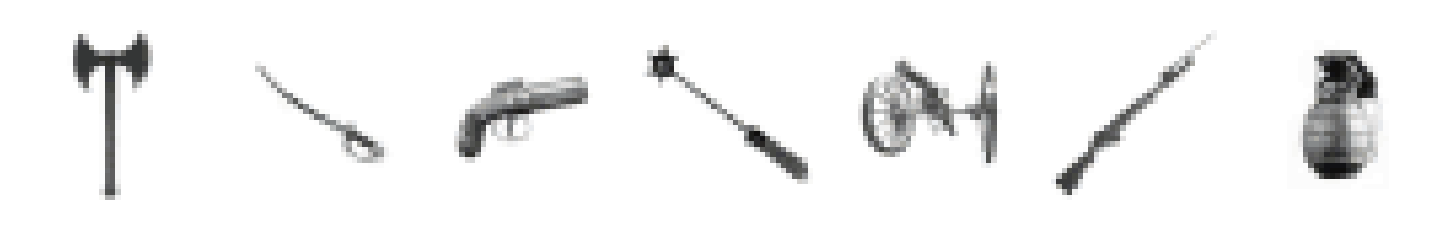

09/05 08:00:44 PM: Running test
09/05 08:00:44 PM: Computing cosine similarities...
09/05 08:00:44 PM: Null hypothesis: no difference between black and white in association to attributes tool and weapon
09/05 08:00:44 PM: Computing pval...
09/05 08:00:44 PM: Using non-parametric test
09/05 08:00:44 PM: Using exact test (924 partitions)
09/05 08:00:44 PM: Equalities contributed 1/924 to p-value
09/05 08:00:44 PM: pval: 0.0021645
09/05 08:00:44 PM: computing effect size...
09/05 08:00:44 PM: esize: 1.64257


(1.6425655, 0.0021645021645021645)

In [7]:
from ieat.api import test

test(
    "data/experiments/weapon/black",
    "data/experiments/weapon/white",
    "data/experiments/weapon/tool",
    "data/experiments/weapon/weapon",
    model_size=model_size,
    models_dir=models_dir,
    clusters_dir=color_clusters_dir,
    n_px=n_px
#     from_cache=False
)

#### Native

09/05 08:11:57 PM: Extracting embeddings for euro


euro


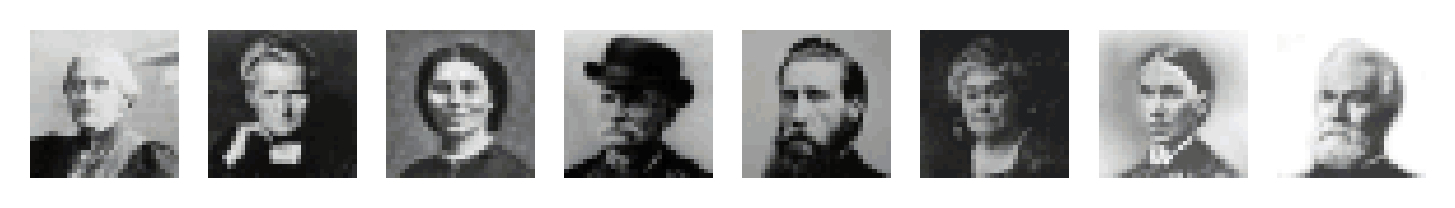

09/05 08:14:39 PM: Extracting embeddings for native


native


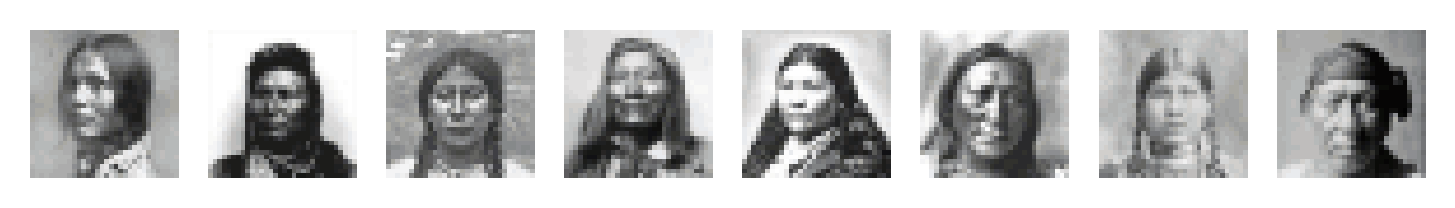

09/05 08:17:20 PM: Extracting embeddings for us


us


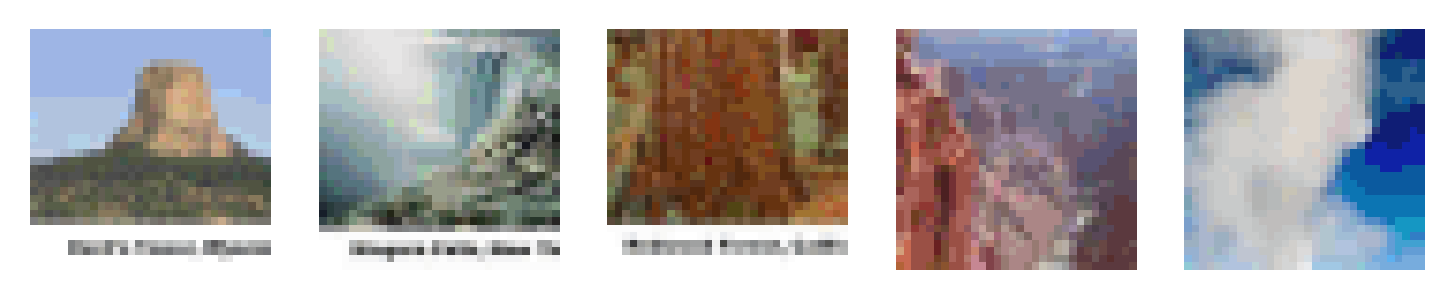

09/05 08:19:02 PM: Extracting embeddings for world


world


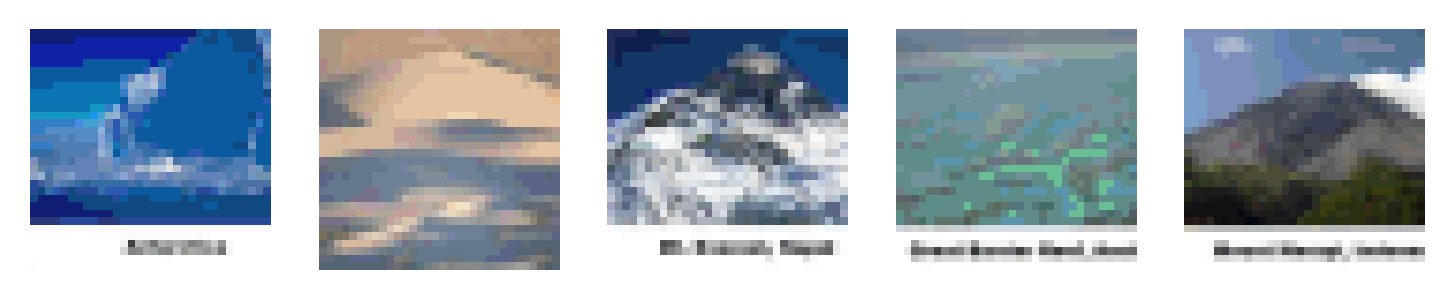

09/05 08:20:44 PM: Running test
09/05 08:20:44 PM: Computing cosine similarities...
09/05 08:20:44 PM: Null hypothesis: no difference between euro and native in association to attributes us and world
09/05 08:20:44 PM: Computing pval...
09/05 08:20:44 PM: Using non-parametric test
09/05 08:20:44 PM: Drawing 9999 samples (and biasing by 1)
09/05 08:20:44 PM: pval: 0.2591
09/05 08:20:44 PM: computing effect size...
09/05 08:20:44 PM: esize: 0.317243


(0.31724274, 0.2591)

In [13]:
test(
    "data/experiments/native/euro",
    "data/experiments/native/native",
    "data/experiments/native/us",
    "data/experiments/native/world",
    model_size=model_size,
    models_dir=models_dir,
    clusters_dir=color_clusters_dir,
    n_px=n_px
#     from_cache=False
)

#### Asian

09/05 08:27:18 PM: Extracting embeddings for european-american


european-american


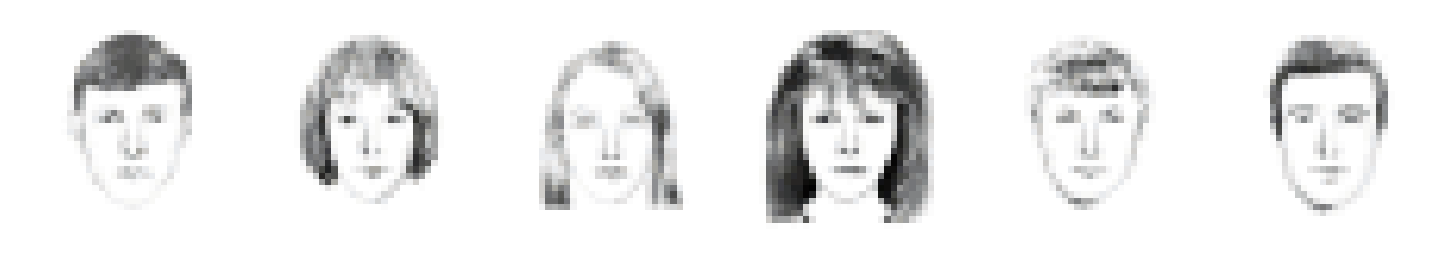

09/05 08:29:19 PM: Extracting embeddings for asian-american


asian-american


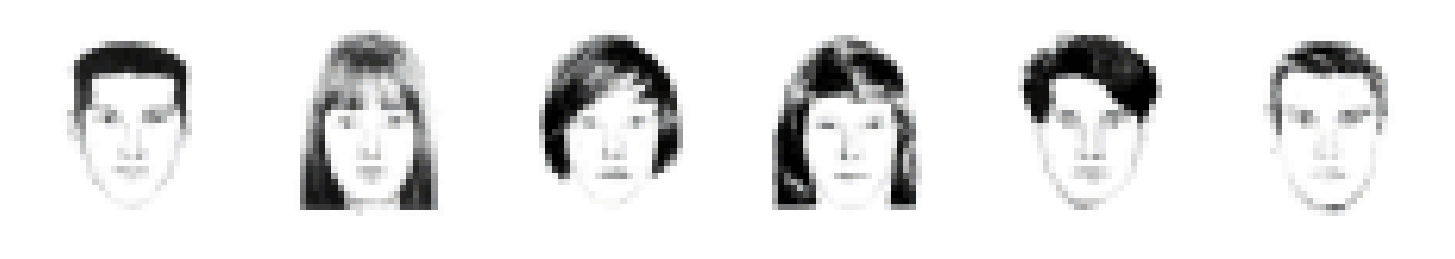

09/05 08:31:22 PM: Extracting embeddings for american


american


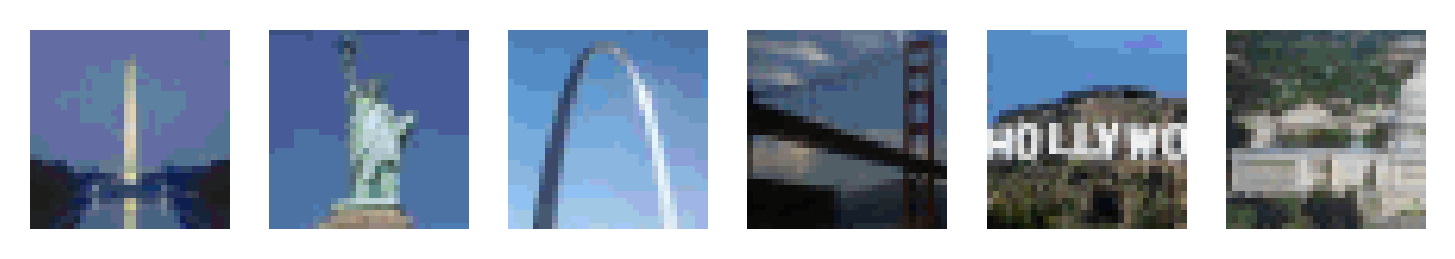

09/05 08:33:24 PM: Extracting embeddings for foreign


foreign


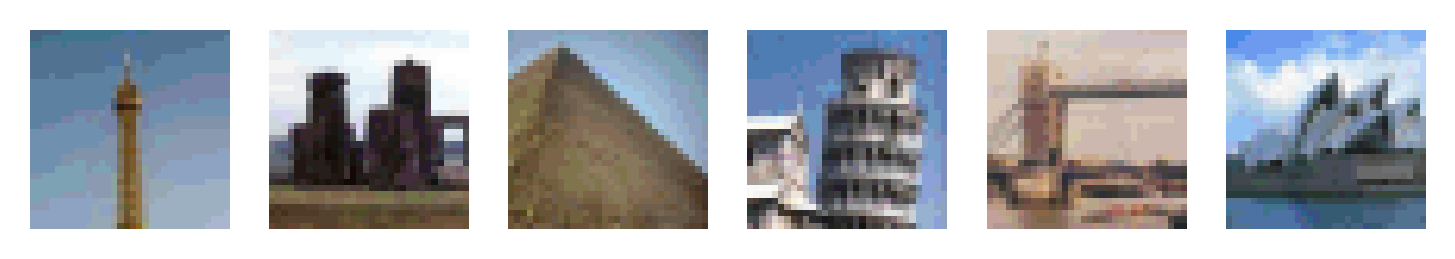

09/05 08:35:29 PM: Running test
09/05 08:35:29 PM: Computing cosine similarities...
09/05 08:35:29 PM: Null hypothesis: no difference between european-american and asian-american in association to attributes american and foreign
09/05 08:35:29 PM: Computing pval...
09/05 08:35:29 PM: Using non-parametric test
09/05 08:35:29 PM: Using exact test (924 partitions)
09/05 08:35:29 PM: Equalities contributed 1/924 to p-value
09/05 08:35:29 PM: pval: 0.357143
09/05 08:35:29 PM: computing effect size...
09/05 08:35:29 PM: esize: 0.252323


(0.25232288, 0.35714285714285715)

In [15]:
test(
    "data/experiments/asian/european-american",
    "data/experiments/asian/asian-american",
    "data/experiments/asian/american",
    "data/experiments/asian/foreign",
    model_size=model_size,
    models_dir=models_dir,
    clusters_dir=color_clusters_dir,
    n_px=n_px
#     from_cache=False
)

#### Insect-Flower

09/05 08:41:44 PM: Extracting embeddings for flower


flower


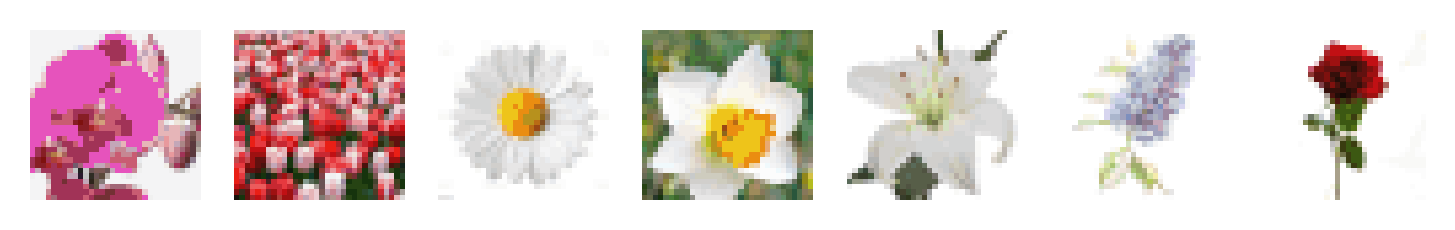

09/05 08:44:06 PM: Extracting embeddings for insect


insect


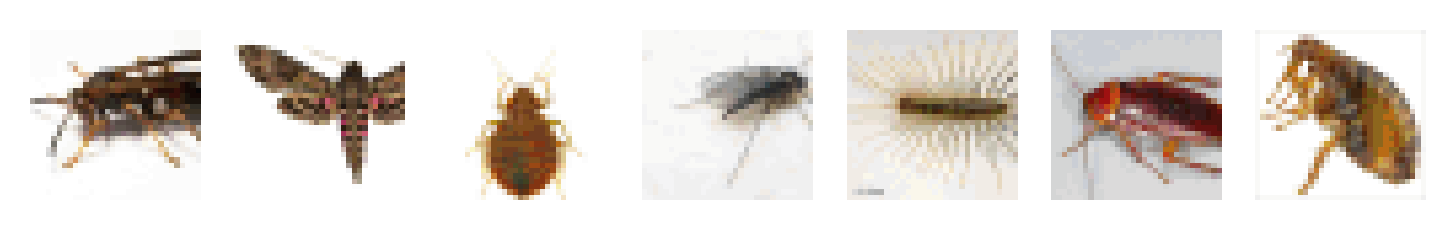

09/05 08:46:30 PM: Extracting embeddings for pleasant-1


pleasant-1


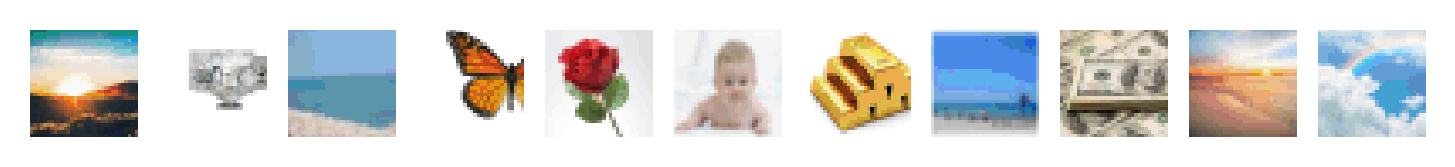

09/05 08:50:13 PM: Extracting embeddings for unpleasant-1


unpleasant-1


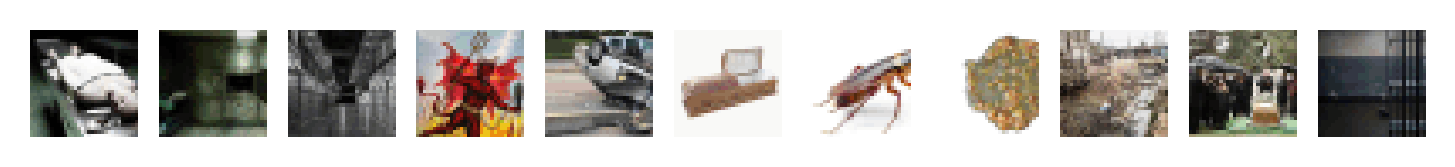

09/05 08:53:57 PM: Running test
09/05 08:53:57 PM: Computing cosine similarities...
09/05 08:53:57 PM: Null hypothesis: no difference between flower and insect in association to attributes pleasant-1 and unpleasant-1
09/05 08:53:57 PM: Computing pval...
09/05 08:53:57 PM: Using non-parametric test
09/05 08:53:57 PM: Using exact test (3432 partitions)
09/05 08:53:57 PM: Equalities contributed 1/3432 to p-value
09/05 08:53:57 PM: pval: 0.678613
09/05 08:53:57 PM: computing effect size...
09/05 08:53:57 PM: esize: -0.418481


(-0.418481, 0.6786130536130536)

In [17]:
from ieat.api import test

test(
    "data/experiments/insect-flower/flower",
    "data/experiments/insect-flower/insect",
    "data/experiments/valence/pleasant-1",
    "data/experiments/valence/unpleasant-1",
    model_size=model_size,
    models_dir=models_dir,
    clusters_dir=color_clusters_dir,
    n_px=n_px,
#     from_cache=False,
    verbose=True
)

#### Weight

09/05 09:01:01 PM: Extracting embeddings for fat


fat


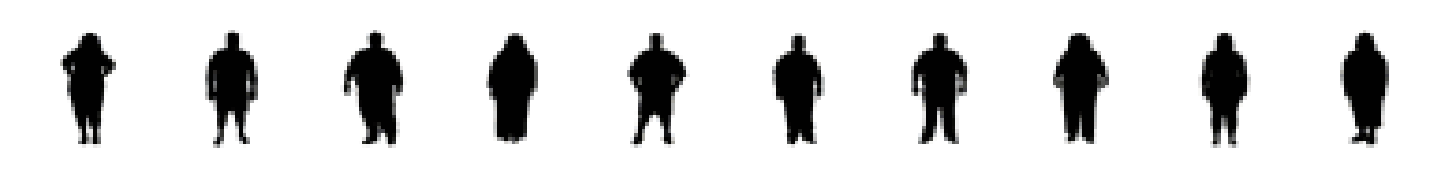

09/05 09:04:25 PM: Extracting embeddings for thin


thin


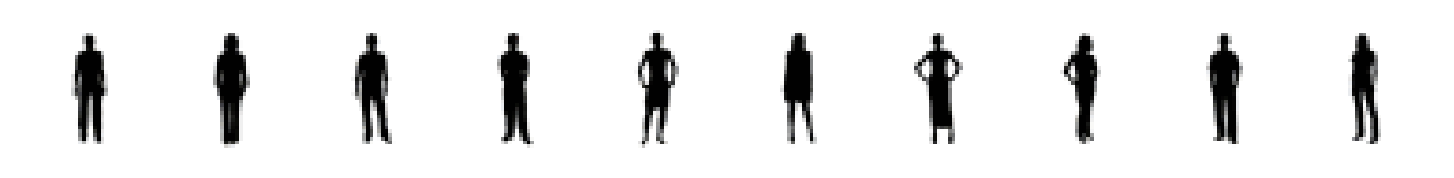

09/05 09:07:46 PM: Loading embeddings for pleasant-1 from file


pleasant-1


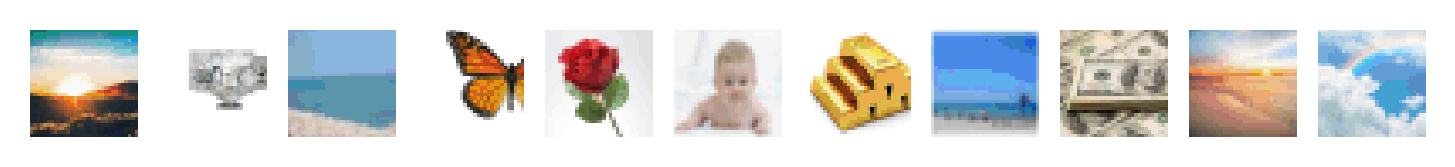

09/05 09:07:46 PM: Loading embeddings for unpleasant-1 from file


unpleasant-1


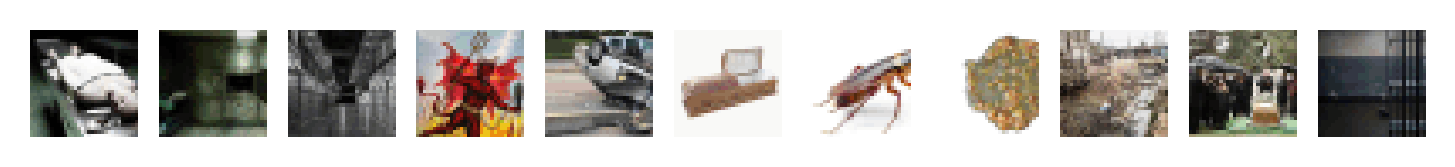

09/05 09:07:47 PM: Running test
09/05 09:07:47 PM: Computing cosine similarities...
09/05 09:07:47 PM: Null hypothesis: no difference between fat and thin in association to attributes pleasant-1 and unpleasant-1
09/05 09:07:47 PM: Computing pval...
09/05 09:07:47 PM: Using non-parametric test
09/05 09:07:47 PM: Drawing 9999 samples (and biasing by 1)
09/05 09:07:48 PM: Equalities contributed 1/10000 to p-value
09/05 09:07:48 PM: pval: 0.1641
09/05 09:07:48 PM: computing effect size...
09/05 09:07:48 PM: esize: 0.441064


(0.4410635478731026, 0.1641)

In [19]:
from ieat.api import test

test(
    "data/experiments/weight/fat",
    "data/experiments/weight/thin",
    "data/experiments/valence/pleasant-1",
    "data/experiments/valence/unpleasant-1",
    model_size=model_size,
    models_dir=models_dir,
    clusters_dir=color_clusters_dir,
    n_px=n_px,
#     from_cache=False,
    verbose=True
)

#### Skin-Tone

09/05 09:15:33 PM: Extracting embeddings for light


light


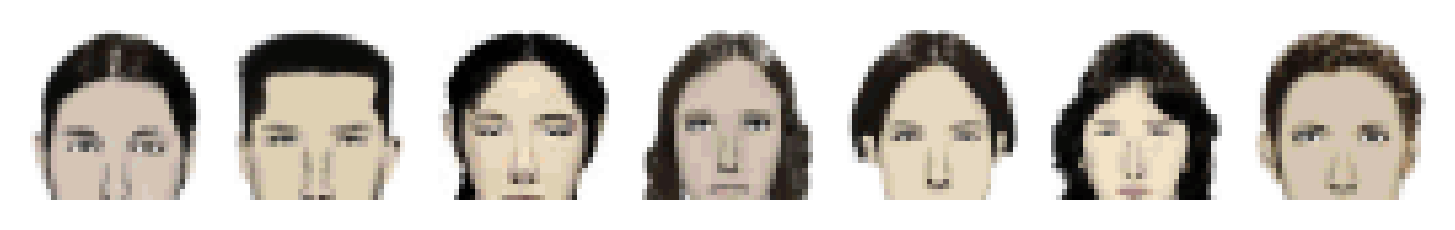

09/05 09:17:57 PM: Extracting embeddings for dark


dark


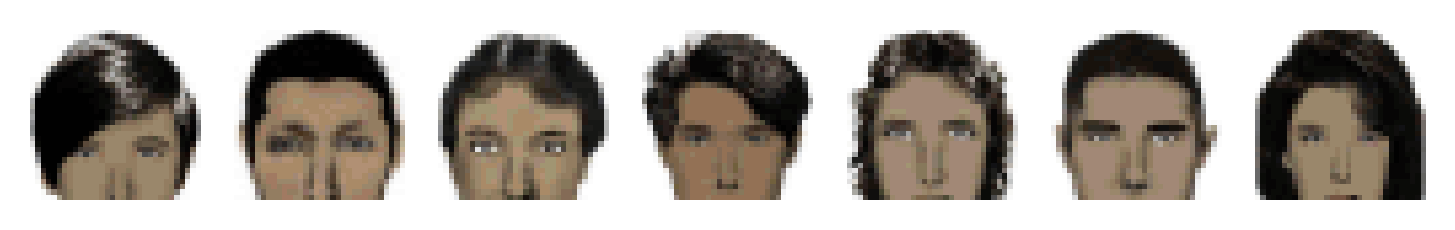

09/05 09:20:17 PM: Loading embeddings for pleasant-1 from file


pleasant-1


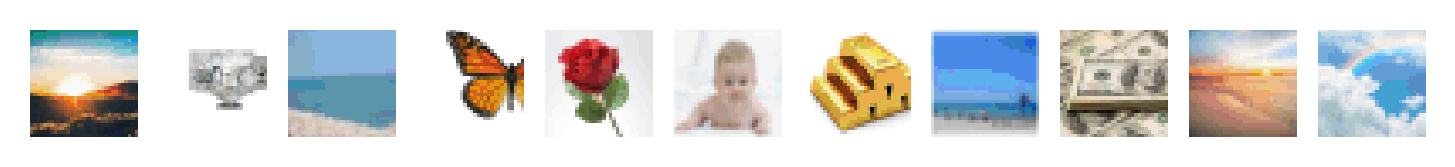

09/05 09:20:17 PM: Loading embeddings for unpleasant-1 from file


unpleasant-1


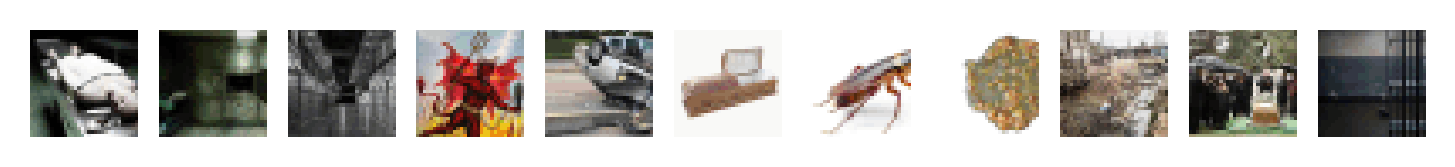

09/05 09:20:18 PM: Running test
09/05 09:20:18 PM: Computing cosine similarities...
09/05 09:20:18 PM: Null hypothesis: no difference between light and dark in association to attributes pleasant-1 and unpleasant-1
09/05 09:20:18 PM: Computing pval...
09/05 09:20:18 PM: Using non-parametric test
09/05 09:20:18 PM: Using exact test (3432 partitions)
09/05 09:20:18 PM: Equalities contributed 1/3432 to p-value
09/05 09:20:18 PM: pval: 0.371795
09/05 09:20:18 PM: computing effect size...
09/05 09:20:18 PM: esize: 0.430093


(0.43009289003326673, 0.3717948717948718)

In [21]:
from ieat.api import test

test(
    "data/experiments/skin-tone/light",
    "data/experiments/skin-tone/dark",
    "data/experiments/valence/pleasant-1",
    "data/experiments/valence/unpleasant-1",
    model_size=model_size,
    models_dir=models_dir,
    clusters_dir=color_clusters_dir,
    n_px=n_px,
#     from_cache=False,
    verbose=True
)

#### Disability

In [ ]:
from ieat.api import test

test(
    "data/experiments/disabled/abled",
    "data/experiments/disabled/disabled",
    "data/experiments/valence/pleasant-1",
    "data/experiments/valence/unpleasant-1",
    model_size=model_size,
    models_dir=models_dir,
    clusters_dir=color_clusters_dir,
    n_px=n_px,
#     from_cache=False,
    verbose=True
)

#### Presidents

In [ ]:
from ieat.api import test

test(
    "data/experiments/presidents/trump",
    "data/experiments/presidents/kennedy",
    "data/experiments/valence/pleasant-1",
    "data/experiments/valence/unpleasant-1",
    model_size=model_size,
    models_dir=models_dir,
    clusters_dir=color_clusters_dir,
    n_px=n_px,
#     from_cache=False,
    verbose=True
)

In [ ]:
from ieat.api import test

test(
    "data/experiments/presidents/trump",
    "data/experiments/presidents/clinton",
    "data/experiments/valence/pleasant-1",
    "data/experiments/valence/unpleasant-1",
    model_size=model_size,
    models_dir=models_dir,
    clusters_dir=color_clusters_dir,
    n_px=n_px,
#     from_cache=False,
    verbose=True
)

09/04 03:42:26 PM: loading weights file models/s/model.ckpt-1000000.index
09/04 03:42:29 PM: Loading embeddings for trump from file


trump


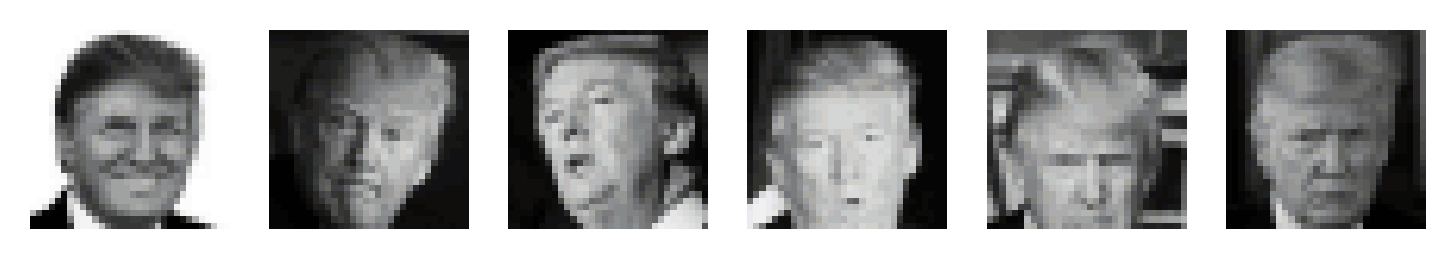

09/04 03:42:30 PM: Loading embeddings for bush from file


bush


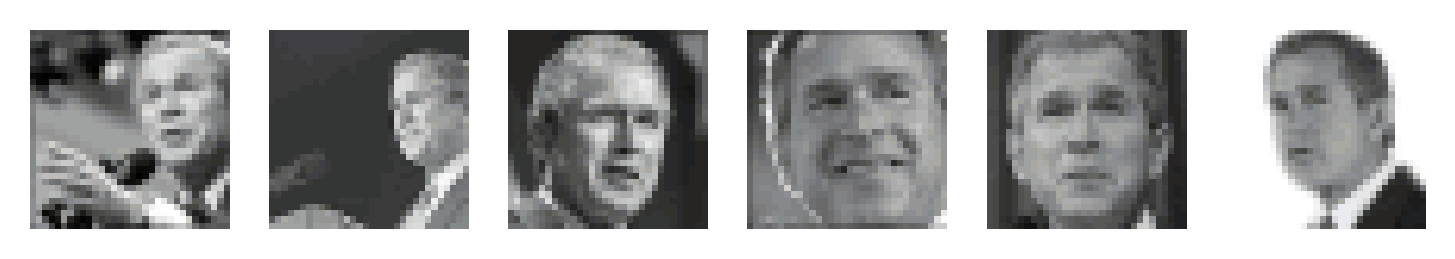

09/04 03:42:30 PM: Loading embeddings for pleasant-1 from file


pleasant-1


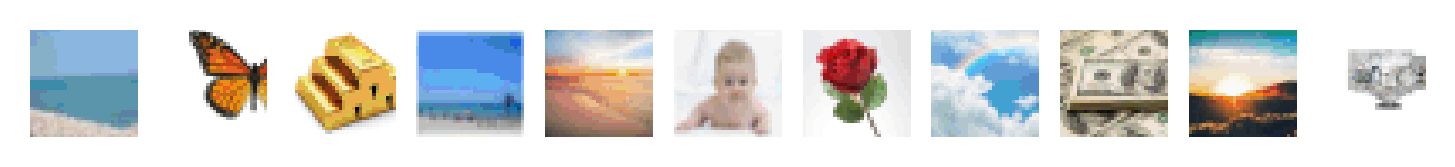

09/04 03:42:31 PM: Loading embeddings for unpleasant-1 from file


unpleasant-1


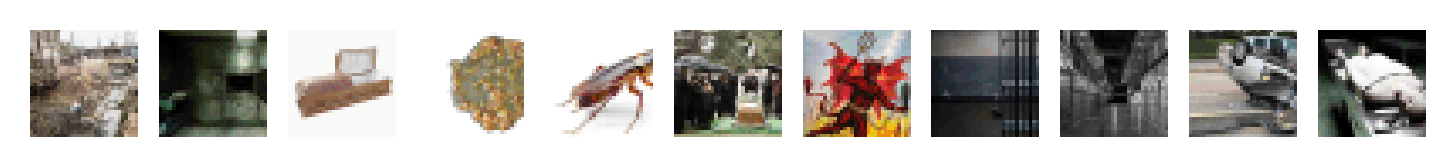

09/04 03:42:31 PM: Running test
09/04 03:42:31 PM: Computing cosine similarities...
09/04 03:42:31 PM: Null hypothesis: no difference between trump and bush in association to attributes pleasant-1 and unpleasant-1
09/04 03:42:31 PM: Computing pval...
09/04 03:42:31 PM: Using non-parametric test
09/04 03:42:31 PM: Using exact test (924 partitions)
09/04 03:42:31 PM: Equalities contributed 1/924 to p-value
09/04 03:42:31 PM: pval: 0.274892
09/04 03:42:31 PM: computing effect size...
09/04 03:42:31 PM: esize: 0.356778


(0.35677750557955945, 0.2748917748917749)

In [ ]:
from ieat.api import test

test(
    "data/experiments/presidents/trump",
    "data/experiments/presidents/bush",
    "data/experiments/valence/pleasant-1",
    "data/experiments/valence/unpleasant-1",
    model_size=model_size,
    models_dir=models_dir,
    clusters_dir=color_clusters_dir,
    n_px=n_px,
#     from_cache=False,
    verbose=True
)

09/04 03:41:12 PM: loading weights file models/s/model.ckpt-1000000.index
09/04 03:41:16 PM: Loading embeddings for trump from file


trump


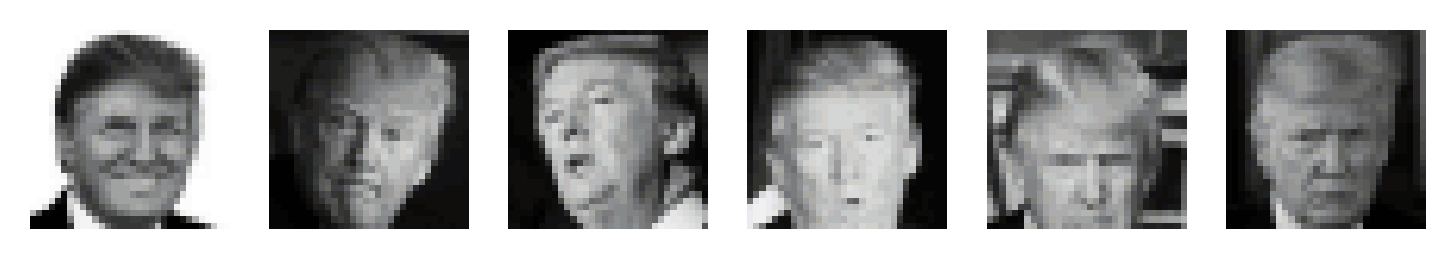

09/04 03:41:16 PM: Loading embeddings for lincoln from file


lincoln


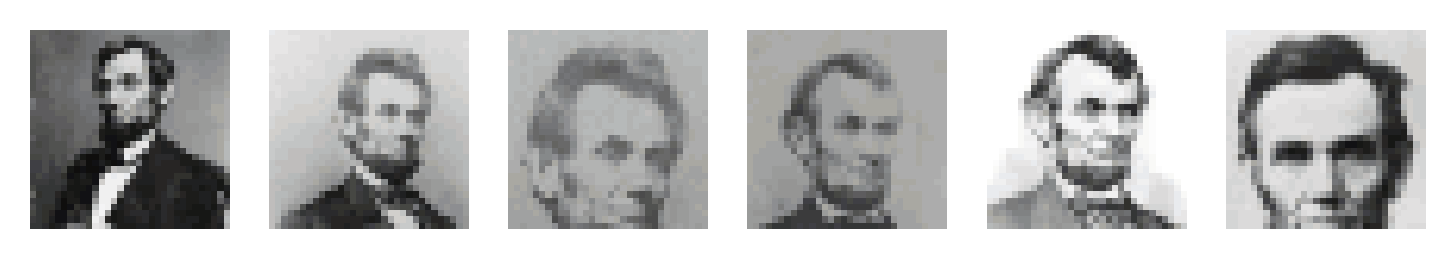

09/04 03:41:16 PM: Loading embeddings for pleasant-1 from file


pleasant-1


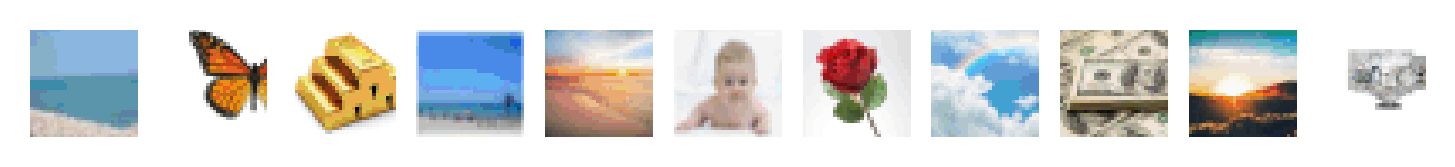

09/04 03:41:17 PM: Loading embeddings for unpleasant-1 from file


unpleasant-1


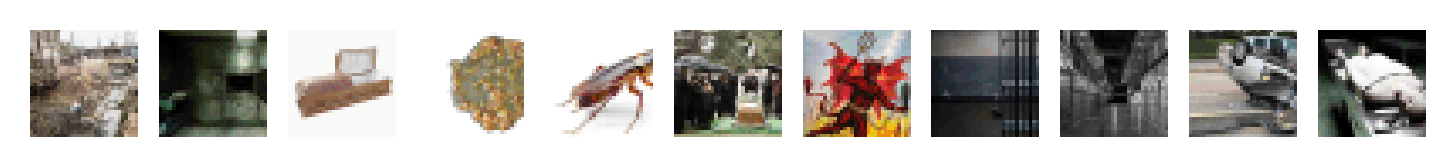

09/04 03:41:18 PM: Running test
09/04 03:41:18 PM: Computing cosine similarities...
09/04 03:41:18 PM: Null hypothesis: no difference between trump and lincoln in association to attributes pleasant-1 and unpleasant-1
09/04 03:41:18 PM: Computing pval...
09/04 03:41:18 PM: Using non-parametric test
09/04 03:41:18 PM: Using exact test (924 partitions)
09/04 03:41:18 PM: Equalities contributed 1/924 to p-value
09/04 03:41:18 PM: pval: 0.0335498
09/04 03:41:18 PM: computing effect size...
09/04 03:41:18 PM: esize: 1.05198


(1.05198421051702, 0.03354978354978355)

In [ ]:
from ieat.api import test

test(
    "data/experiments/presidents/trump",
    "data/experiments/presidents/lincoln",
    "data/experiments/valence/pleasant-1",
    "data/experiments/valence/unpleasant-1",
    model_size=model_size,
    models_dir=models_dir,
    clusters_dir=color_clusters_dir,
    n_px=n_px,
#     from_cache=False,
    verbose=True
)

#### Religion

09/05 02:17:52 PM: loading weights file models/s/model.ckpt-1000000.index
09/05 02:17:56 PM: Loading embeddings for judaism from file


judaism


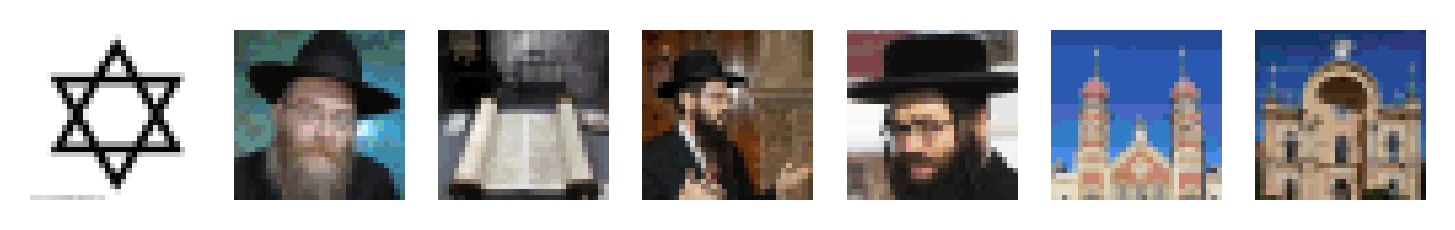

09/05 02:17:57 PM: Loading embeddings for christianity from file


christianity


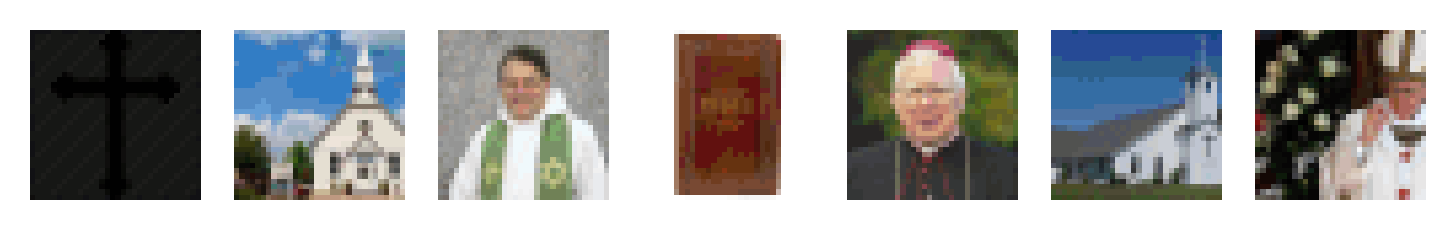

09/05 02:17:57 PM: Loading embeddings for pleasant-1 from file


pleasant-1


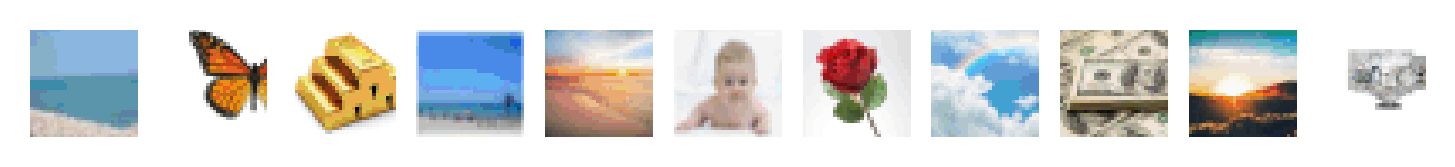

09/05 02:17:58 PM: Loading embeddings for unpleasant-1 from file


unpleasant-1


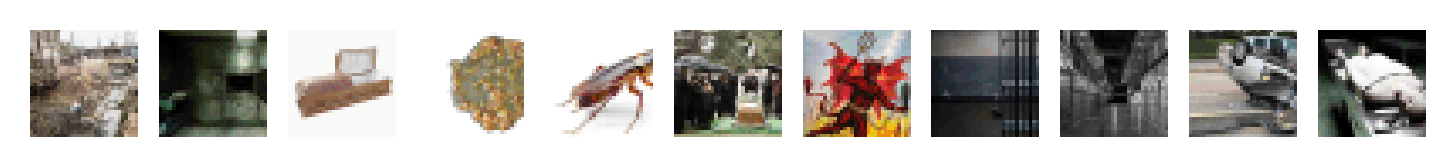

09/05 02:17:59 PM: Running test
09/05 02:17:59 PM: Computing cosine similarities...
09/05 02:17:59 PM: Null hypothesis: no difference between judaism and christianity in association to attributes pleasant-1 and unpleasant-1
09/05 02:17:59 PM: Computing pval...
09/05 02:17:59 PM: Using non-parametric test
09/05 02:17:59 PM: Using exact test (3432 partitions)
09/05 02:17:59 PM: Equalities contributed 1/3432 to p-value
09/05 02:17:59 PM: pval: 0.359557
09/05 02:17:59 PM: computing effect size...
09/05 02:17:59 PM: esize: 0.204081


(0.2040810933458653, 0.35955710955710957)

In [ ]:
from ieat.api import test

test(
    "data/experiments/religion/judaism",
    "data/experiments/religion/christianity",
    "data/experiments/valence/pleasant-1",
    "data/experiments/valence/unpleasant-1",
    model_size=model_size,
    models_dir=models_dir,
    clusters_dir=color_clusters_dir,
    n_px=n_px,
#     from_cache=False,
    verbose=True
)

#### Gender-Science

09/05 02:25:32 PM: loading weights file models/s/model.ckpt-1000000.index
09/05 02:25:36 PM: Extracting embeddings for science


science


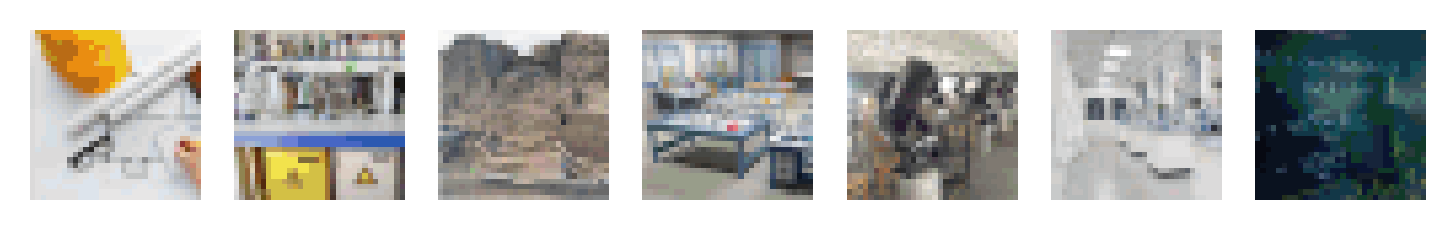

09/05 02:26:06 PM: Extracting embeddings for liberal-arts


liberal-arts


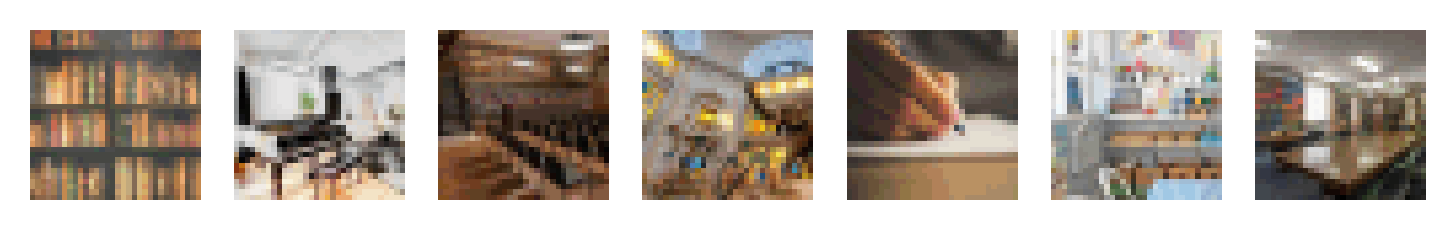

09/05 02:26:35 PM: Extracting embeddings for male


male


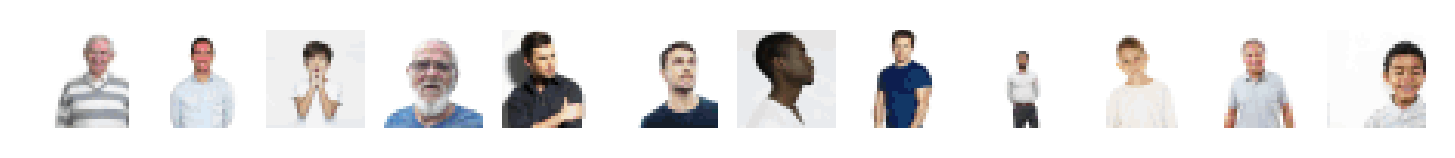

09/05 02:27:28 PM: Extracting embeddings for female


female


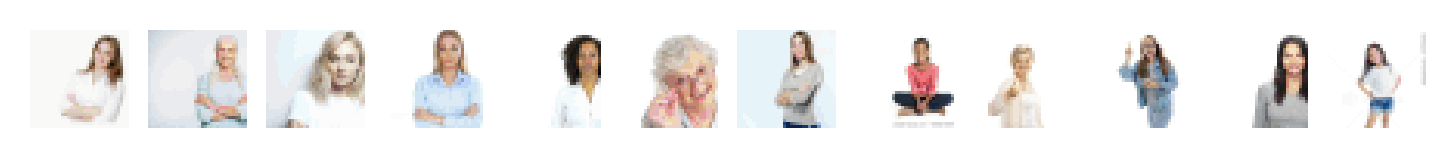

09/05 02:28:16 PM: Running test
09/05 02:28:16 PM: Computing cosine similarities...
09/05 02:28:16 PM: Null hypothesis: no difference between science and liberal-arts in association to attributes male and female
09/05 02:28:16 PM: Computing pval...
09/05 02:28:16 PM: Using non-parametric test
09/05 02:28:16 PM: Using exact test (3432 partitions)
09/05 02:28:16 PM: Equalities contributed 1/3432 to p-value
09/05 02:28:16 PM: pval: 0.488928
09/05 02:28:16 PM: computing effect size...
09/05 02:28:16 PM: esize: 0.0145627


(0.014562695, 0.48892773892773894)

In [ ]:
from ieat.api import test

test(
    "data/experiments/gender/science",
    "data/experiments/gender/liberal-arts",
    "data/experiments/gender/male",
    "data/experiments/gender/female",
    model_size=model_size,
    models_dir=models_dir,
    clusters_dir=color_clusters_dir,
    n_px=n_px,
#     from_cache=False,
    verbose=True
)

#### Gender-Career

09/05 02:41:04 PM: loading weights file models/s/model.ckpt-1000000.index
09/05 02:41:08 PM: Extracting embeddings for career


career


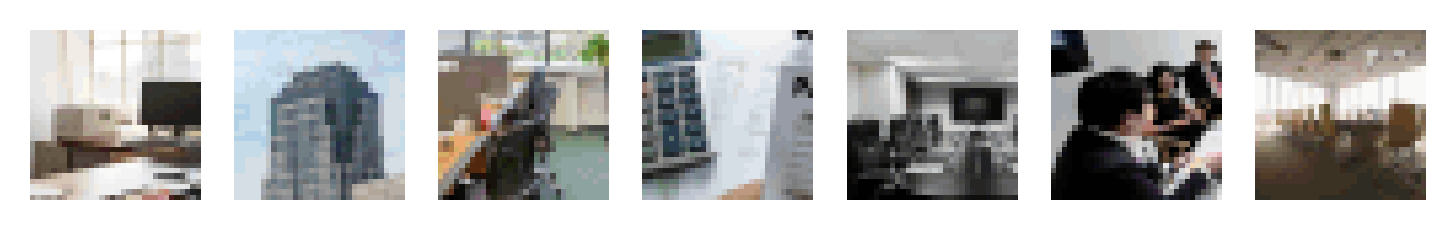

09/05 02:41:35 PM: Extracting embeddings for family


family


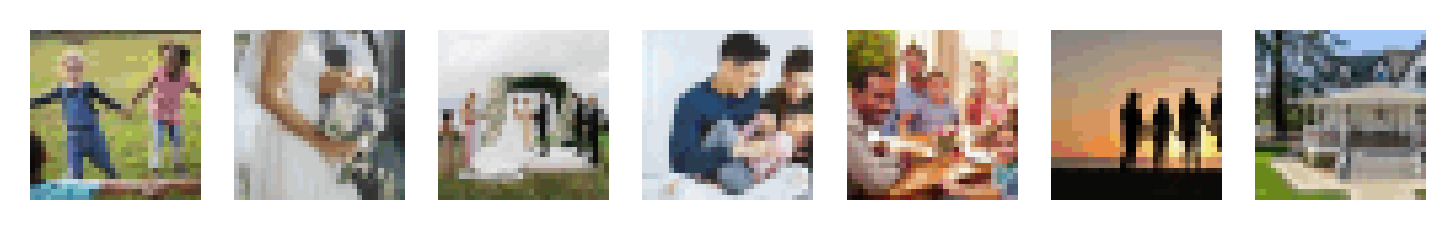

09/05 02:42:02 PM: Loading embeddings for male from file


male


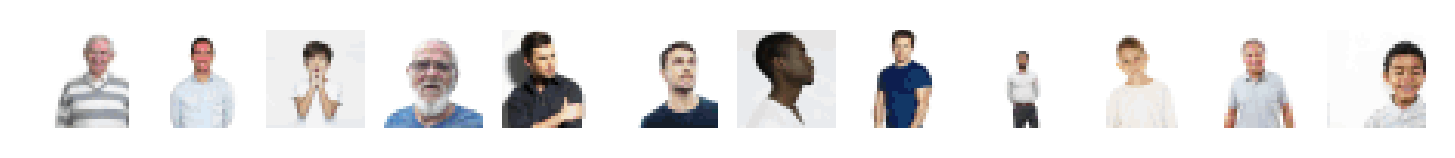

09/05 02:42:02 PM: Loading embeddings for female from file


female


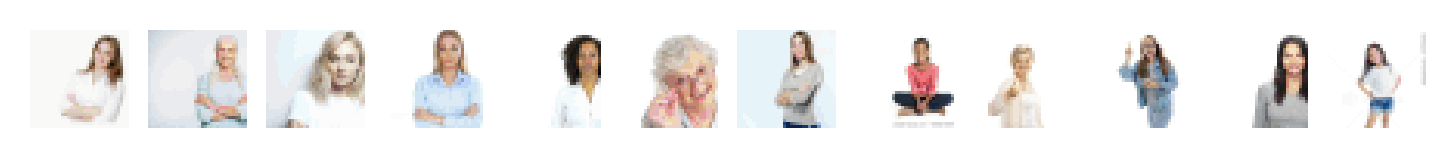

09/05 02:42:03 PM: Running test
09/05 02:42:03 PM: Computing cosine similarities...
09/05 02:42:03 PM: Null hypothesis: no difference between career and family in association to attributes male and female
09/05 02:42:03 PM: Computing pval...
09/05 02:42:03 PM: Using non-parametric test
09/05 02:42:03 PM: Using exact test (3432 partitions)
09/05 02:42:03 PM: Equalities contributed 1/3432 to p-value
09/05 02:42:03 PM: pval: 0.308566
09/05 02:42:03 PM: computing effect size...
09/05 02:42:03 PM: esize: 0.282932


(0.2829324699528706, 0.30856643356643354)

In [ ]:
from ieat.api import test

test(
    "data/experiments/gender/career",
    "data/experiments/gender/family",
    "data/experiments/gender/male",
    "data/experiments/gender/female",
    model_size=model_size,
    models_dir=models_dir,
    clusters_dir=color_clusters_dir,
    n_px=n_px,
#     from_cache=False,
    verbose=True
)

#### Sexuality

09/05 03:01:23 PM: loading weights file models/s/model.ckpt-1000000.index
09/05 03:01:26 PM: Loading embeddings for gay from file


gay


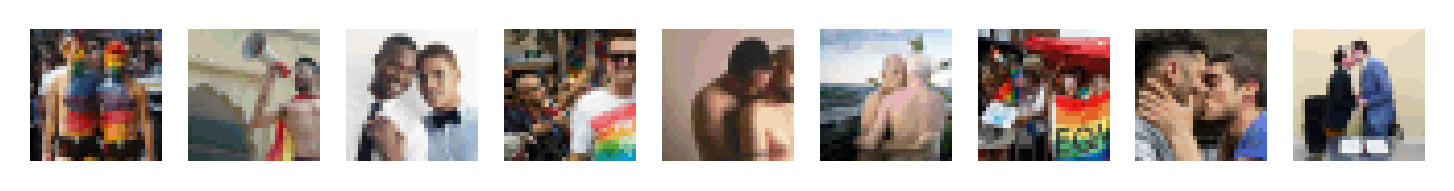

09/05 03:01:27 PM: Loading embeddings for straight from file


straight


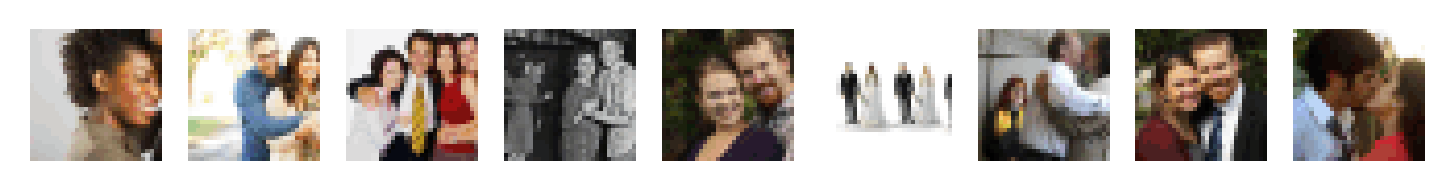

09/05 03:01:27 PM: Loading embeddings for pleasant-1 from file


pleasant-1


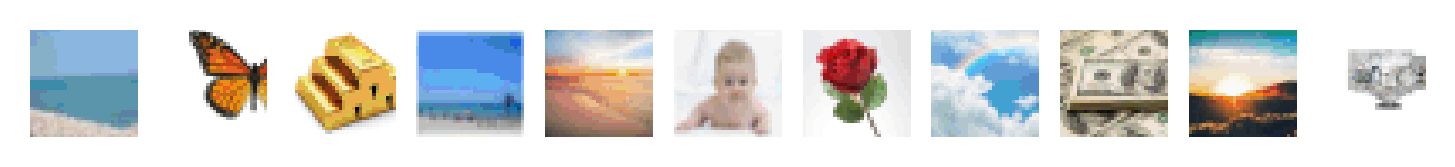

09/05 03:01:28 PM: Loading embeddings for unpleasant-1 from file


unpleasant-1


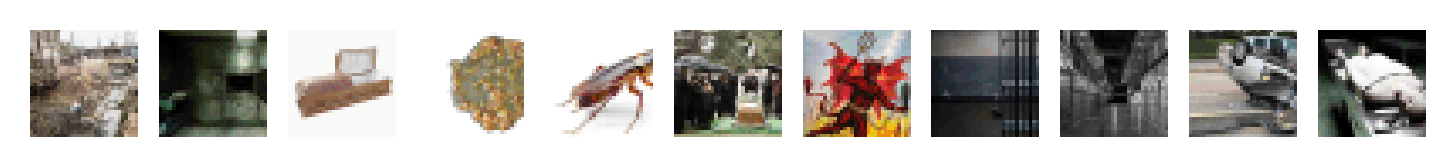

09/05 03:01:29 PM: Running test
09/05 03:01:29 PM: Computing cosine similarities...
09/05 03:01:29 PM: Null hypothesis: no difference between gay and straight in association to attributes pleasant-1 and unpleasant-1
09/05 03:01:29 PM: Computing pval...
09/05 03:01:29 PM: Using non-parametric test
09/05 03:01:29 PM: Drawing 9999 samples (and biasing by 1)
09/05 03:01:29 PM: pval: 0.0613
09/05 03:01:29 PM: computing effect size...
09/05 03:01:29 PM: esize: 0.598859


(0.5988591076611683, 0.0613)

In [ ]:
from ieat.api import test

test(
    "data/experiments/sexuality/gay",
    "data/experiments/sexuality/straight",
    "data/experiments/valence/pleasant-1",
    "data/experiments/valence/unpleasant-1",
    model_size=model_size,
    models_dir=models_dir,
    clusters_dir=color_clusters_dir,
    n_px=n_px,
#     from_cache=False,
    verbose=True
)

#### Race

09/05 03:04:43 PM: loading weights file models/s/model.ckpt-1000000.index
09/05 03:04:47 PM: Loading embeddings for african-american from file


african-american


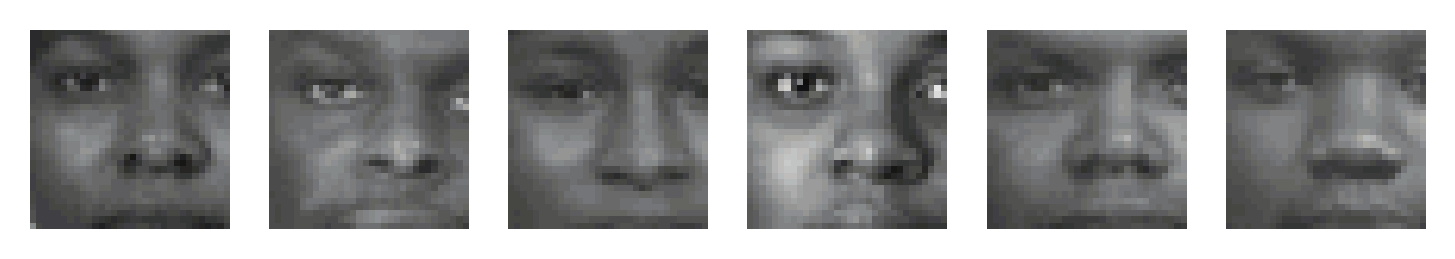

09/05 03:04:48 PM: Loading embeddings for european-american from file


european-american


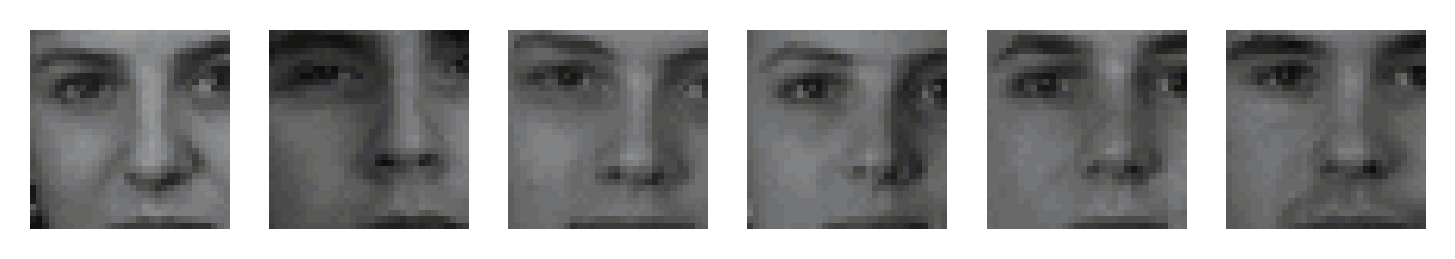

09/05 03:04:48 PM: Loading embeddings for pleasant-1 from file


pleasant-1


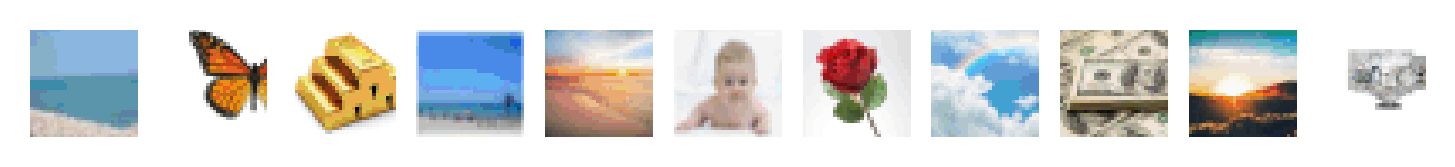

09/05 03:04:49 PM: Loading embeddings for unpleasant-1 from file


unpleasant-1


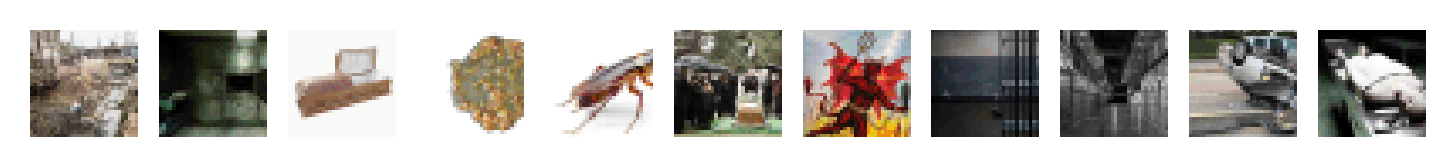

09/05 03:04:49 PM: Running test
09/05 03:04:49 PM: Computing cosine similarities...
09/05 03:04:49 PM: Null hypothesis: no difference between african-american and european-american in association to attributes pleasant-1 and unpleasant-1
09/05 03:04:49 PM: Computing pval...
09/05 03:04:49 PM: Using non-parametric test
09/05 03:04:49 PM: Using exact test (924 partitions)
09/05 03:04:49 PM: Equalities contributed 1/924 to p-value
09/05 03:04:49 PM: pval: 0.0768398
09/05 03:04:49 PM: computing effect size...
09/05 03:04:49 PM: esize: 0.841935


(0.8419353040430634, 0.07683982683982683)

In [ ]:
from ieat.api import test

test(
    "data/experiments/race/african-american",
    "data/experiments/race/european-american",
    "data/experiments/valence/pleasant-1",
    "data/experiments/valence/unpleasant-1",
    model_size=model_size,
    models_dir=models_dir,
    clusters_dir=color_clusters_dir,
    n_px=n_px,
#     from_cache=False,
    verbose=True
)

#### Arab-Muslim

09/05 03:18:44 PM: loading weights file models/s/model.ckpt-1000000.index
09/05 03:18:48 PM: Extracting embeddings for other-people


other-people


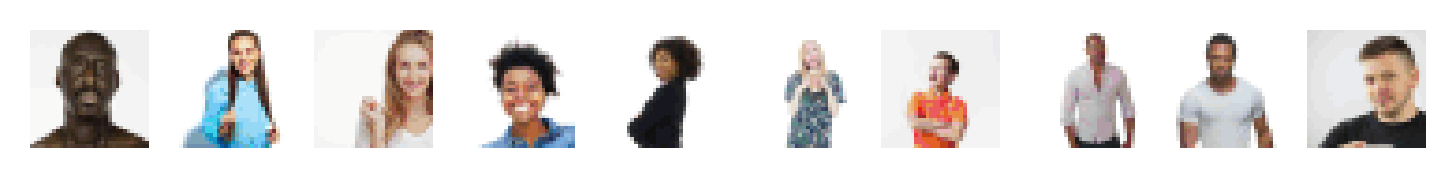

09/05 03:19:22 PM: Extracting embeddings for arab-muslim


arab-muslim


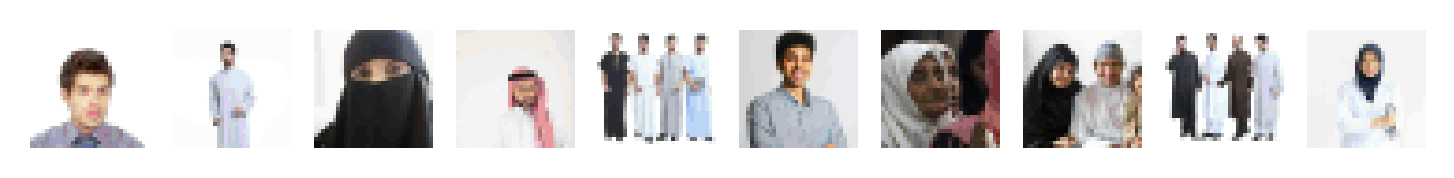

09/05 03:19:57 PM: Loading embeddings for pleasant-1 from file


pleasant-1


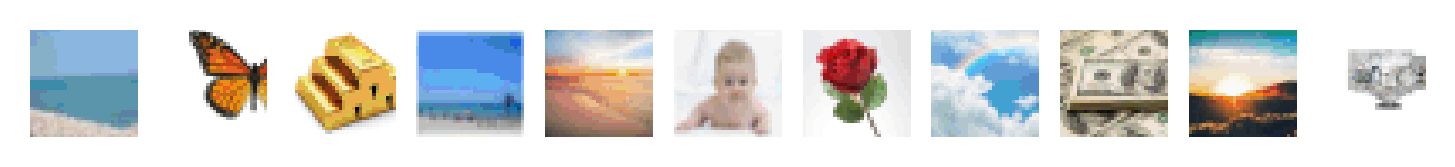

09/05 03:19:58 PM: Loading embeddings for unpleasant-1 from file


unpleasant-1


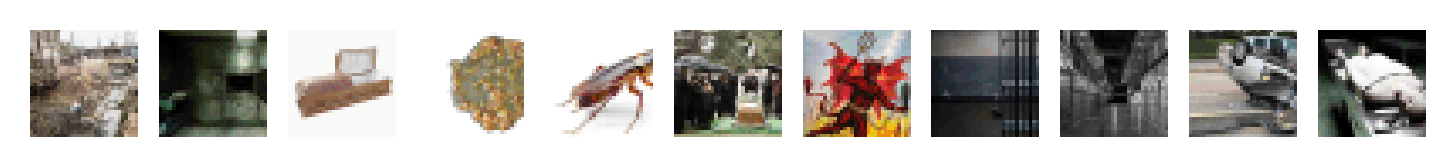

09/05 03:19:59 PM: Running test
09/05 03:19:59 PM: Computing cosine similarities...
09/05 03:19:59 PM: Null hypothesis: no difference between other-people and arab-muslim in association to attributes pleasant-1 and unpleasant-1
09/05 03:19:59 PM: Computing pval...
09/05 03:19:59 PM: Using non-parametric test
09/05 03:19:59 PM: Drawing 9999 samples (and biasing by 1)
09/05 03:19:59 PM: pval: 0.1486
09/05 03:19:59 PM: computing effect size...
09/05 03:19:59 PM: esize: 0.483114


(0.48311387536782197, 0.1486)

In [ ]:
from ieat.api import test

test(
    "data/experiments/arab-muslim/other-people",
    "data/experiments/arab-muslim/arab-muslim",
    "data/experiments/valence/pleasant-1",
    "data/experiments/valence/unpleasant-1",
    model_size=model_size,
    models_dir=models_dir,
    clusters_dir=color_clusters_dir,
    n_px=n_px,
#     from_cache=False,
    verbose=True
)

#### Age

09/05 03:28:42 PM: loading weights file models/s/model.ckpt-1000000.index
09/05 03:28:46 PM: Loading embeddings for old from file


old


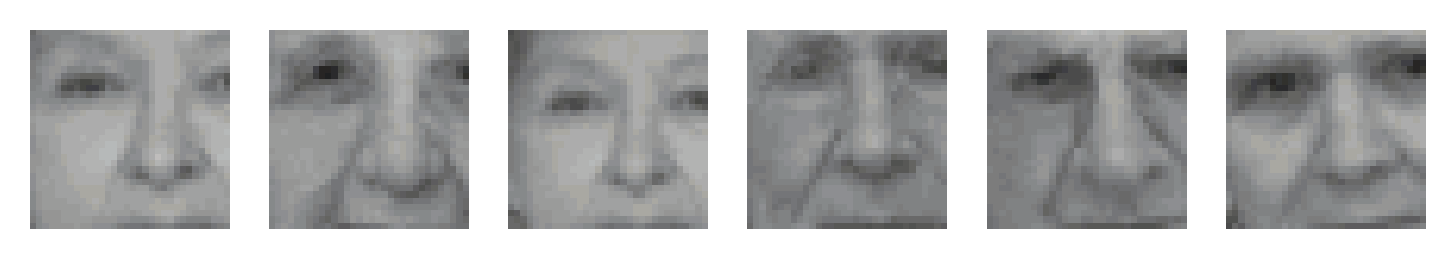

09/05 03:28:46 PM: Loading embeddings for young from file


young


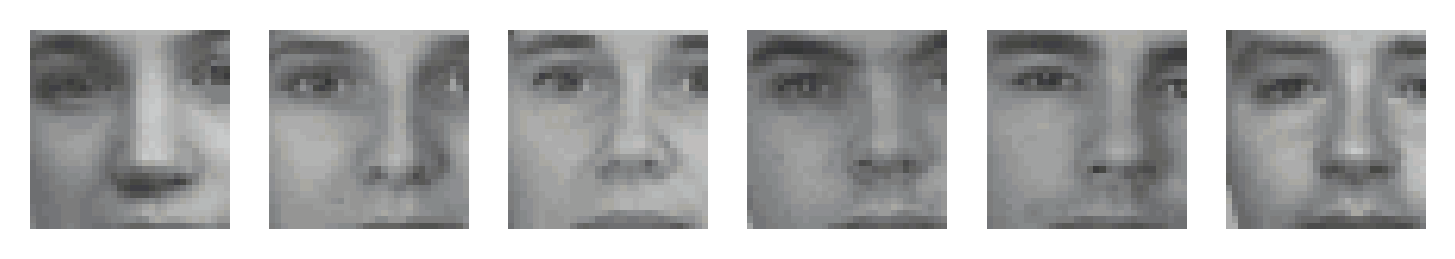

09/05 03:28:46 PM: Loading embeddings for pleasant-1 from file


pleasant-1


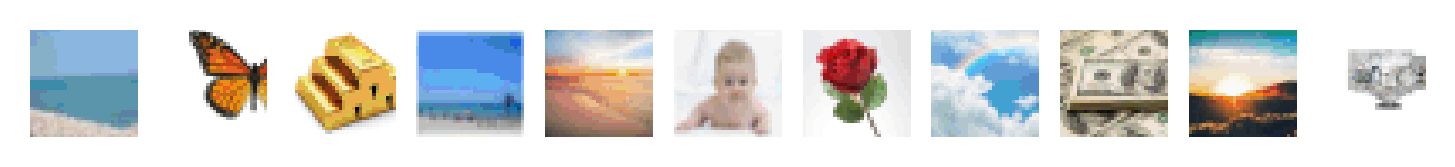

09/05 03:28:47 PM: Loading embeddings for unpleasant-1 from file


unpleasant-1


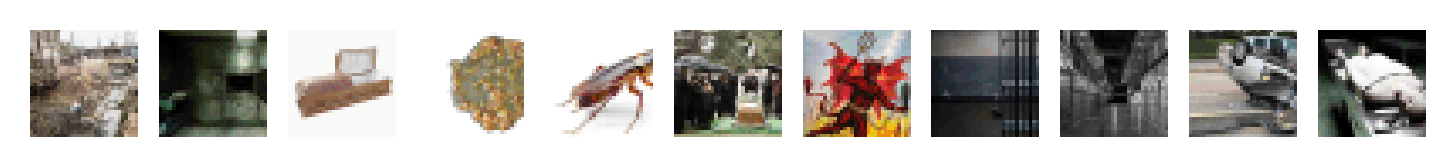

09/05 03:28:48 PM: Running test
09/05 03:28:48 PM: Computing cosine similarities...
09/05 03:28:48 PM: Null hypothesis: no difference between old and young in association to attributes pleasant-1 and unpleasant-1
09/05 03:28:48 PM: Computing pval...
09/05 03:28:48 PM: Using non-parametric test
09/05 03:28:48 PM: Using exact test (924 partitions)
09/05 03:28:48 PM: Equalities contributed 1/924 to p-value
09/05 03:28:48 PM: pval: 0.392857
09/05 03:28:48 PM: computing effect size...
09/05 03:28:48 PM: esize: 0.167543


(0.167543483735061, 0.39285714285714285)

In [ ]:
from ieat.api import test

test(
    "data/experiments/age/old",
    "data/experiments/age/young",
    "data/experiments/valence/pleasant-1",
    "data/experiments/valence/unpleasant-1",
    model_size=model_size,
    models_dir=models_dir,
    clusters_dir=color_clusters_dir,
    n_px=n_px,
#     from_cache=False,
    verbose=True
)

### Download Cached Embeddings

In [20]:
# to download from colab
from google.colab import files

!zip -r embeddings_colab.zip embeddings
files.download("embeddings_colab.zip")

updating: embeddings/ (stored 0%)
updating: embeddings/gender_career_s_32.csv (deflated 51%)
updating: embeddings/presidents_clinton_s_32.csv (deflated 51%)
updating: embeddings/valence_unpleasant_s_32.csv (deflated 54%)
updating: embeddings/valence_pleasant_s_32.csv (deflated 54%)
updating: embeddings/native_native_s_32.csv (deflated 51%)
updating: embeddings/race_european-american_s_32.csv (deflated 51%)
updating: embeddings/native_euro_s_32.csv (deflated 51%)
updating: embeddings/disabled_abled_s_32.csv (deflated 51%)
updating: embeddings/asian_american_s_32.csv (deflated 52%)
updating: embeddings/arab-muslim_other-people_s_32.csv (deflated 53%)
updating: embeddings/disabled_disabled_s_32.csv (deflated 51%)
updating: embeddings/weapon_tool_s_32.csv (deflated 53%)
updating: embeddings/asian_l.csv (deflated 53%)
updating: embeddings/native_l.csv (deflated 53%)
updating: embeddings/native_world_s_32.csv (deflated 53%)
updating: embeddings/insect-flower_insect_s_32.csv (deflated 52%)
up

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>